In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from datetime import date, timedelta
import matplotlib.pyplot as plt

# Data Cleaning

In [129]:
#read in csv data
daily = pd.read_csv('BTCdaily.csv')
exchange = pd.read_csv('Conversions.csv', low_memory = False)
SNP = pd.read_csv('SNP500.csv')
gold  = pd.read_csv('gold.csv')
oil = pd.read_csv('oil.csv')

#convert date column from object to datetime and set as index
daily['date'] = pd.to_datetime(daily['date'])
exchange['date']= pd.to_datetime(exchange['Currency'])
SNP['Date'] = pd.to_datetime(SNP['Date'])
gold['date'] = pd.to_datetime(gold['date'])
oil['date'] = pd.to_datetime(oil['date'])

exchange = exchange.set_index('date')['2014-11-28':'2022-02-28'] #only include dates that we have Bitcoin data for
daily = daily.set_index('date')
SNP = SNP.set_index('Date')
gold = gold.set_index('date')
oil = oil.set_index('date')
gold = gold.rename(columns = {' value':'valueGold'})
oil = oil.rename(columns = {' valueOil':'valueOil'})


#merge all three dataframes on date
df = pd.merge(daily, exchange, left_index = True, right_index = True).fillna(method = 'bfill') #fill null with previous day values
df = pd.merge(df, SNP, left_index = True, right_index = True).fillna(method = 'bfill')
df = pd.merge(df, gold, left_index = True, right_index = True).fillna(method = 'bfill')
df = pd.merge(df, oil, left_index = True, right_index = True)

#drop unnecessary columns from dataframe
to_drop = ['Currency','AED:UAE dirham','ALL:Lek','ARS:Argentine peso','AUD:Australian dollar','BGN:Lev','BHD:Bahraini dinar',
           'BND:Brunei dollar','BRL:Brazilian real','BAM:Bosnian convertible mark','EUR:Euro.1','CLP:Chilean peso',
           'CNY:Renminbi','COP:Colombian peso','EUR:Euro.2','CZK:Czech koruna','EUR:Euro.3','DKK:Danish krone',
           'DZD:Algerian dinar','EUR:Euro.4','EUR:Euro.5','EUR:Euro.6','EUR:Euro.7','EUR:Euro.8',
           'HKD:Hong Kong dollar','HRK:Kuna','HUF:Forint','IDR:Rupiah','EUR:Euro.9','ILS:New shekel',
           'IRR:Iranian rial','INR:Indian rupee','ISK:Icelandic krona','EUR:Euro.10', 'UYU:Uruguayan peso','VEF:Bolivar',
           'EUR:Euro.18','XDR:Special drawing right', 'KRW:Won','KWD:Kuwaiti dinar','KZT:Tenge',
           'LKR:Sri Lanka rupee','EUR:Euro.11','EUR:Euro.12','EUR:Euro.13','MKD:Denar','EUR:Euro.14',
           'MUR:Mauritius rupee','MXN:Mexican peso','MYR:Malaysian ringgit','EUR:Euro.15','NOK:Norwegian krone',
           'NPR:Nepalese rupee','NZD:New Zealand dollar','OMR:Omani rial','PEN:Sol','PHP:Philippine peso',
           'PKR:Pakistan rupee','PLN:Zloty','EUR:Euro.16','QAR:Qatari riyal','RON:Romanian leu','RSD:Serbian Dinar',
           'RUB:Russian rouble','SAR:Saudi riyal','SEK:Swedish krona','SGD:Singapore dollar','EUR:Euro.17',
           'THB:Baht','TND:Tunisian dinar','TRY:Turkish lira','TTD:Trinidad and Tobago dollar',
           'TWD:New Taiwan dollar','UAH:Hryvnia', 'USD:US dollar','ZAR:South African Rand', 
           'unix', 'symbol','high','low','HighSNP','LowSNP', 'Adj CloseSNP']
df = df.drop(columns = to_drop)

df.info() #examine data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1802 entries, 2022-02-28 to 2014-11-28
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  1802 non-null   float64
 1   close                 1802 non-null   float64
 2   Volume BTC            1802 non-null   float64
 3   Volume USD            1802 non-null   float64
 4   EUR:Euro              1802 non-null   float64
 5   CAD:Canadian dollar   1802 non-null   float64
 6   CHF:Swiss franc       1802 non-null   float64
 7   GBP:Pound (sterling)  1802 non-null   float64
 8   JPY:Yen               1802 non-null   float64
 9   OpenSNP               1802 non-null   object 
 10  CloseSNP              1802 non-null   object 
 11  VolumeSNP             1802 non-null   object 
 12  valueGold             1802 non-null   float64
 13  valueOil              1802 non-null   float64
dtypes: float64(11), object(3)
memory usage: 211.2+ KB


In [130]:
df.replace(',','', regex=True, inplace=True) #get rid of commas in S&P data so we can use it as numeric
df = df.apply(pd.to_numeric, errors='ignore') 
df.head()

,open,close,Volume BTC,Volume USD,EUR:Euro,CAD:Canadian dollar,CHF:Swiss franc,GBP:Pound (sterling),JPY:Yen,OpenSNP,CloseSNP,VolumeSNP,valueGold,valueOil
2022-02-28,37717.10,43178.98,3160.618070,1.364723e+08,0.892937,1.273685,0.922940,0.746049,115.465667,4354.17,4373.94,4594010000,1900.7,95.720
2022-02-25,38360.93,39231.64,2202.851827,8.642149e+07,0.891583,1.277193,0.927068,0.746612,115.584879,4298.38,4384.65,3941780000,1887.6,91.590
2022-02-24,37253.26,38376.88,6302.850957,2.418838e+08,0.895817,1.282451,0.924483,0.747675,114.915345,4155.77,4288.70,5070560000,1926.3,92.810
2022-02-23,38269.94,37274.18,1778.275258,6.628375e+07,0.881523,1.268865,0.919517,0.735746,115.109309,4324.93,4225.50,3814340000,1910.4,92.100
2022-02-22,37036.98,38269.94,2388.759035,9.141766e+07,0.881679,1.273232,0.918886,0.737833,115.094340,4332.74,4304.76,4007780000,1907.4,91.998


In [131]:
#create some new columns for analysis 
df['changeBTC'] = df['close'] - df['open']
df['changeSNP'] = df['CloseSNP'] - df['OpenSNP']

#binary increase columns for classifier models
df.loc[df['changeBTC'] > 0, 'BTCincreased'] = 1
df.loc[df['changeBTC'] <= 0, 'BTCincreased'] = 0
df.loc[df['changeSNP'] > 0 , 'SNPincreased'] = 1
df.loc[df['changeSNP'] <= 0, 'SNPincreased'] = 0

df['lagChangeSNP'] = df['changeSNP'].shift(-1)
df['lagChangeGold'] = df['valueGold'].shift(-1)-df['valueGold'].shift(-2)
df['lagOil'] = df['valueOil'].shift(-1)-df['valueOil'].shift(-2)

#Lag columns for moving average
for i in range (1,6):
    df['Lag' + str(i)] = df['close'].shift(-i)
    
df['movingAvg'] = (df['Lag1']+df['Lag2']+df['Lag3']+df['Lag4']+df['Lag5'])/5

#Create a column that counts the days from the beginning of the dataset, so that we can use the date as a predictor
df = df.reset_index()
df['dayNumber'] = (df['index'] - df['index'].min()).dt.days
df = df.set_index('index')

# Choosing a Model

## Classifier models using binary variable of BTCincreased

In [133]:
#Split train and test sets for cross validation
x_columns = ['Volume BTC', 'EUR:Euro', 'CAD:Canadian dollar','CHF:Swiss franc','GBP:Pound (sterling)', 'JPY:Yen', 'VolumeSNP','valueGold','lagChangeGold','lagChangeSNP', 'lagOil', 'dayNumber']
train = df['2022-02-01':'2020-01-01']
test  = df['2022-03-01':'2022-02-01']
X_train = train[x_columns]
y_train = train['BTCincreased']
X_test = test[x_columns]
y_test = test['BTCincreased']

### Logistic Regression

In [134]:
log = LogisticRegression()
log.fit(X_train,y_train)
logpred = log.predict(X_test)

### Random Forest  Classifier

In [135]:
for i in range(1,len(x_columns)+1):
    rfc = RandomForestClassifier(random_state = 1, max_features = i, max_depth = 10)
    rfc.fit(X_train, y_train)
    rfcpred = rfc.predict(X_test)
    print("Accuracy score of random forest classifier for", i, "features is:", accuracy_score(y_test, rfcpred))

Accuracy score of random forest classifier for 1 features is: 0.6842105263157895
Accuracy score of random forest classifier for 2 features is: 0.5263157894736842
Accuracy score of random forest classifier for 3 features is: 0.6842105263157895
Accuracy score of random forest classifier for 4 features is: 0.5789473684210527
Accuracy score of random forest classifier for 5 features is: 0.5263157894736842
Accuracy score of random forest classifier for 6 features is: 0.5789473684210527
Accuracy score of random forest classifier for 7 features is: 0.47368421052631576
Accuracy score of random forest classifier for 8 features is: 0.631578947368421
Accuracy score of random forest classifier for 9 features is: 0.631578947368421
Accuracy score of random forest classifier for 10 features is: 0.631578947368421
Accuracy score of random forest classifier for 11 features is: 0.5789473684210527
Accuracy score of random forest classifier for 12 features is: 0.5789473684210527


In [141]:
rfc = RandomForestClassifier(random_state = 1, max_depth = 10, max_features = 3)
rfc.fit(X_train, y_train)
rfcpred = rfc.predict(X_test)

<AxesSubplot:>

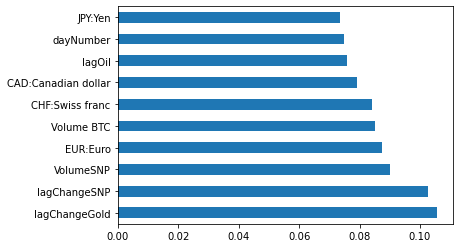

In [142]:
#plot feature importances
feat_importances = pd.Series(rfc.feature_importances_, index=x_columns)
feat_importances.nlargest(10).plot(kind='barh')

### AdaBoost Classifier

In [138]:
ada = AdaBoostClassifier(n_estimators = 50, random_state = 1)
ada.fit(X_train, y_train)
adapred = ada.predict(X_test)

### Naive Bayes Classifier

In [139]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nbpred = nb.predict(X_test)

### Accuracy scores and choosing the best classifier model

In [140]:
print("Accuracy score of logistic regression is:", accuracy_score(y_test, logpred))
print("Accuracy score of random forest classifier is:", accuracy_score(y_test, rfcpred))
print("Accuracy score of ada boost classifier is:", accuracy_score(y_test, adapred))
print("Accuracy score for Naive Bayes is:", accuracy_score(y_test, nbpred))

Accuracy score of logistic regression is: 0.631578947368421
Accuracy score of random forest classifier is: 0.5263157894736842
Accuracy score of ada boost classifier is: 0.7894736842105263
Accuracy score for Naive Bayes is: 0.631578947368421


The boosting classifier, which uses a decision tree and "boosts" by making more decision trees using the residuals, has by far the highest accuracy score, predicting correctly whether Bitcoin will increase or decrease with 78% accuracy. However, it would be more useful to be able to accurately predict the actual price of Bitcoin, so we will try to create regression models using the monetary change in Bitcoin value as our y variable. 

## Regression models using continuous variable of changeBTC

In [143]:
#Change y variable for regression
y_train = train['changeBTC']
y_test = test['changeBTC']

### Linear Regression

In [144]:
lin = LinearRegression()
lin.fit(X_train, y_train)
linpred = lin.predict(X_test) 

### Lasso Regression

In [145]:
las = Lasso()
las.fit(X_train, y_train)
laspred = las.predict(X_test)

###  Random Forest Regression

In [146]:
rfr = RandomForestRegressor(max_features = 2, random_state = 1)
rfr.fit(X_train, y_train)
rfrpred = rfr.predict(X_test)

### Boosting Regressor

In [147]:
abr = AdaBoostRegressor(n_estimators = 50, random_state = 1)
abr.fit(X_train, y_train)
abrpred = abr.predict(X_test)

### Measuring accuracy of regressor models using RMSE

In [148]:
print("RMSE for linear regression is:", mean_squared_error(y_test, linpred, squared = False))
print("RMSE for Lasso regression is:", mean_squared_error(y_test, laspred, squared = False))
print("RMSE for Random Forest regression is:", mean_squared_error(y_test, rfrpred, squared = False))
print("RMSE for ada boost regression is:", mean_squared_error(y_test, abrpred, squared = False))

RMSE for linear regression is: 2210.522239344135
RMSE for Lasso regression is: 2198.4636179672293
RMSE for Random Forest regression is: 2233.2294350611223
RMSE for ada boost regression is: 2369.5011223955175


The best regression model based on root mean squared error is ada boost regression, with random forest coming close behind. However, the RMSE is quite high for all 4 models, showing that it is much tougher to predict the actual change price of Bitcoin than it is to just predict whether it will go up or down. 

# Exponential Smoothing Forecasting

Time series forecasting is another way we will attempt to predict Bitcoin prices, which uses previous values to forecast the next period. Two popular methods to do this are moving averages and exponential smoothing, which we will use in this analysis. We use a 5 period moving average in this project, and will use an alpha of 0.5 in our exponential smoothing forecasting. 

In [19]:
df.head()

,open,close,Volume BTC,Volume USD,EUR:Euro,CAD:Canadian dollar,CHF:Swiss franc,GBP:Pound (sterling),JPY:Yen,OpenSNP,...,changeSNP,BTCincreased,SNPincreased,Lag1,Lag2,Lag3,Lag4,Lag5,movingAvg,dayNumber
index,,,,,,,,,,,,,,,,,,,,,
2022-02-28,37717.10,43178.98,3160.618070,1.364723e+08,0.892937,1.273685,0.922940,0.746049,115.465667,4354.17,...,19.77,1.0,1.0,39231.64,38376.88,37274.18,38269.94,39996.99,38629.926,2649
2022-02-25,38360.93,39231.64,2202.851827,8.642149e+07,0.891583,1.277193,0.927068,0.746612,115.584879,4298.38,...,86.27,1.0,1.0,38376.88,37274.18,38269.94,39996.99,40556.11,38894.820,2646
2022-02-24,37253.26,38376.88,6302.850957,2.418838e+08,0.895817,1.282451,0.924483,0.747675,114.915345,4155.77,...,132.93,1.0,1.0,37274.18,38269.94,39996.99,40556.11,43901.48,39999.740,2645
2022-02-23,38269.94,37274.18,1778.275258,6.628375e+07,0.881523,1.268865,0.919517,0.735746,115.109309,4324.93,...,-99.43,0.0,0.0,38269.94,39996.99,40556.11,43901.48,44582.48,41461.400,2644
2022-02-22,37036.98,38269.94,2388.759035,9.141766e+07,0.881679,1.273232,0.918886,0.737833,115.094340,4332.74,...,-27.98,1.0,0.0,39996.99,40556.11,43901.48,44582.48,42540.30,42315.472,2643


The columns Lag1-Lag5 show the previous 5 days of Bitcoin prices, and the movingAvg column shows us the 5 period moving average for our forecast. 

In [20]:
df['movAvgError'] = df['close']-df['movingAvg']

In [21]:
def expSmoothing(data, forecast_periods, alpha):
    data = np.array(data)
    cols = len(data)
    data = np.append(data, [np.nan]*forecast_periods)
    forecast = np.full(cols+forecast_periods, np.nan)
    forecast[1] = data[0]
    for t in range(2,cols+1):  
        forecast[t] = alpha*data[t-1]+(1-alpha)*forecast[t-1]
    forecast[cols+1:] = forecast[t]
    df = pd.DataFrame.from_dict({"ActualPrice":data,"ExpSmForecast":forecast,"ExpSmError":data-forecast})
    return df

In [22]:
df = df.sort_index(ascending = True)
expSmoothingDf = expSmoothing(df['close'], 1, 0.5)
df = df.reset_index()
df = pd.merge(df, expSmoothingDf, left_index = True, right_index = True)
df = df.set_index('index').sort_index(ascending = False)

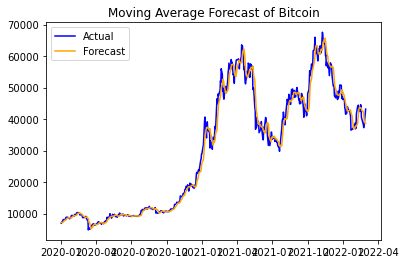

In [23]:
plt.plot(df['2022-02-28':'2020-01-01'].index.values, df['2022-02-28':'2020-01-01']['ActualPrice'], color = 'b', label = 'Actual')
plt.plot(df['2022-02-28':'2020-01-01'].index.values, df['2022-02-28':'2020-01-01']['movingAvg'], color = 'orange', label = "Forecast")
plt.title("Moving Average Forecast of Bitcoin")
plt.legend()
plt.show()

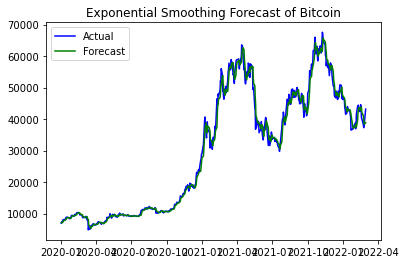

In [24]:
plt.plot(df['2022-03-01':'2020-01-01'].index.values, df['2022-02-28':'2020-01-01']['ActualPrice'], color = 'b', label = 'Actual')
plt.plot(df['2022-03-01':'2020-01-01'].index.values, df['2022-02-28':'2020-01-01']['ExpSmForecast'], color = 'g', label = 'Forecast')
plt.title("Exponential Smoothing Forecast of Bitcoin")
plt.legend()
plt.show()

In [25]:
print("Average error using 5 period moving average is", df['2022-02-28':'2020-01-01']['movAvgError'].mean(), "dollars")
print("Average error using exponential smoothing is", df['2022-02-28':'2020-01-01']['ExpSmError'].mean(), "dollars")

Average error using 5 period moving average is 182.0667024029577 dollars
Average error using exponential smoothing is 124.9674878169756 dollars


It is hard to compare these errors with the error from the regression modeling due to the different nature of each style of prediction, but we can see that the exponential smoothing model tends to be more accurate than the moving average, which is typical when using time series forecasting. However, the average error is large enough that we cannot reliably predict the price of Bitcoin using these time series forecasting models. Since the average error is positive for both, this suggests that the forecast tends to be lower than the actual price on average. In order to get a better representation of the error, we need to look at the absolute value of the forecast error and use the mean of this to see how far off the forecast is.

In [26]:
print("Average absolute error using 5 period moving average is", df['2022-02-28':'2020-01-01']['movAvgError'].abs().mean(), "dollars")
print("Average absolute error using exponential smoothing is", df['2022-02-28':'2020-01-01']['ExpSmError'].abs().mean(), "dollars")

Average absolute error using 5 period moving average is 1604.8768096118313 dollars
Average absolute error using exponential smoothing is 1243.0989607568017 dollars
